## Imports

In [1]:
from imutils import paths
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Activation,Flatten,Dropout
from keras import backend as K
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from keras.preprocessing.image import ImageDataGenerator,img_to_array
from keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle
import os
import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MultiLabelBinarizer

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Train-Validation split

In [3]:
imagePaths = sorted(list(paths.list_images("imgs/")))
random.seed(40)
random.shuffle(imagePaths)
train_imagePaths,val_imagePaths=train_test_split(imagePaths,test_size=0.1)

In [4]:
len(train_imagePaths),len(val_imagePaths)

(15386, 1710)

## Genrating labels using MultiLabelBinarizer

In [5]:
labels=pd.read_csv("train.csv")

labels_all=[]
for i in list(set(labels.color)):
    for j in list(set(labels.type)):
        labels_all.append(tuple([i,j]))
unique_labels=set(labels_all)        

unique_labels_list=list(unique_labels)
mlb = MultiLabelBinarizer()
mlb.fit(unique_labels_list)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [6]:
len(mlb.classes_)

20

In [7]:
mlb.classes_

array(['beige', 'black', 'blazer', 'blue', 'brown', 'dress', 'green',
       'grey', 'hoodie', 'indigo', 'jacket', 'jeans', 'multicolor',
       'orange', 'pink', 'purple', 'red', 'shirt & t-shirt', 'white',
       'yellow'], dtype=object)

## Generators

In [9]:
## Data size is huge, so generators are used for consuming elements batchwise.
nb_rows=96
nb_cols=96
nb_channel=3

In [10]:
def normalize_data(data):
    return data/127.5-1

def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size,nb_rows, nb_cols, nb_channel)) 
    batch_labels = np.zeros((batch_size,len(mlb.classes_))) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [13]:
len(imagePaths)
curr_dt_time = datetime.datetime.now()

In [14]:
## tried image aug but accuracy didnt improve

# def get_random_affine():
#     dx, dy = np.random.randint(-1.7, 1.8, 2)
#     M = np.float32([[1, 0, dx], [0, 1, dy]])
#     return M

In [15]:
def load_batch_images(batch_num, batch_size, t):
    batch_data,batch_labels = init_batch_data(batch_size)
    start_idx=batch_num*batch_size
    end_idx=start_idx+batch_size
    list_images=t[start_idx:end_idx]
    idx=0
    for i in list_images:
        image = cv2.imread(i, cv2.IMREAD_COLOR)
        if image is None or image.shape==(0,0,0):
            continue
        else:
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
            resized_norm=normalize_data(resized)
            batch_data[idx] = resized_norm
            labels_list=[]
            labels_list.append(tuple([labels.loc[labels.uid==i.split("/")[-1].split(".jpg")[0]][["color","type"]].values[0][0],labels.loc[labels.uid==i.split("/")[-1].split(".jpg")[0]][["color","type"]].values[0][1]]))
            batch_labels[idx]=mlb.transform(labels_list)
            idx+=1
        
    return batch_data,batch_labels

def generator(imagePaths,batch_size):
    
    while True:
        t = np.random.permutation(imagePaths)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images( batch, batch_size, t)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(train_imagePaths) != batch_size*num_batches):
            batch_size = len(train_imagePaths) - (batch_size*num_batches)
            yield load_batch_images(batch, batch_size, t)


def build(width,height,depth,classes,act="softmax"):
    model=Sequential()
    inputShape=(height,width,depth)
    chanDim=-1
    if K.image_data_format()=="channels_first":
        inputShape=(depth,height,width)
        chanDim=1
    ## conv-relu-pool
    model.add(Conv2D(32,(3,3),padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    ##conv-relu *2 ,pool
    model.add(Conv2D(64,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    ## conv-relu*2,pool
    model.add(Conv2D(128,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    ## flatten

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    ##
    model.add(Dense(classes))
    model.add(Activation(act))

    return model

model=build(nb_rows,nb_cols,nb_channel,classes=len(mlb.classes_),act="sigmoid")

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)       

In [17]:
epochs=1
INIT_LR=1e-4
batch_size= 32
IMAGE_DIMS = (96, 96, 3)

In [18]:
optimiser = Adam(learning_rate=INIT_LR) #write your optimizer
model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=["accuracy"])
train_generator = generator(train_imagePaths,batch_size)
val_generator = generator(val_imagePaths,batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [20]:
num_train_sequences=len(train_imagePaths)
num_val_sequences=len(val_imagePaths)

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
print(steps_per_epoch,validation_steps)

481 54


## Loading model wieights

In [24]:
model.load_weights("models/model-00001-0.05778-0.97879-0.00000-0.99802.h5")

In [28]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1
481/481 [==============================] - 950s 2s/step - loss: 0.0721 - accuracy: 0.9739 - val_loss: 5.3696e-21 - val_accuracy: 0.9976

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model_init_2020-02-0205_10_33.338186/model-00001-0.07214-0.97390-0.00000-0.99760.h5


In [208]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1
481/481 [==============================] - 1502s 3s/step - loss: 0.0660 - accuracy: 0.9760 - val_loss: 0.5781 - val_accuracy: 0.9532

Epoch 00001: val_loss improved from inf to 0.57812, saving model to model_init_2020-02-0310_03_30.616889/model-00001-0.06605-0.97598-0.57812-0.95320.h5


In [31]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1
481/481 [==============================] - 1174s 2s/step - loss: 0.0600 - accuracy: 0.9782 - val_loss: 2.3410e-17 - val_accuracy: 0.9980

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model_init_2020-02-0311_19_13.708401/model-00001-0.05998-0.97818-0.00000-0.99795.h5


In [18]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1
481/481 [==============================] - 1029s 2s/step - loss: 0.0578 - accuracy: 0.9788 - val_loss: 6.5608e-17 - val_accuracy: 0.9980

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model_init_2020-02-0316_52_18.049499/model-00001-0.05778-0.97879-0.00000-0.99802.h5


## Predict function

In [25]:
import time
labels=pd.read_csv("train.csv")
labels_all=[]
for i in list(set(labels.color)):
    for j in list(set(labels.type)):
        labels_all.append(tuple([i,j]))
unique_labels=set(labels_all)        

unique_labels_list=list(unique_labels)
mlb = MultiLabelBinarizer()
mlb.fit(unique_labels_list)

##helper function for normalizing test data
def normalize_data(data):
    return data/127.5-1

##helper function for getting color and type
def get_color_type(pred_classes):
    if pred_classes[0] in color_list:
        color=pred_classes[0]
        type_dress=pred_classes[1]
    else:
        color=pred_classes[1]
        type_dress=pred_classes[0]
    return color,type_dress

color_list=set(labels.color)
dress_type=set(labels.type)

nb_rows=96
nb_cols=96
nb_channel=3

start_time=time.time()

def predict(path_to_test_csv,imgs_directory="imgs/test/"):
    '''path_to_test_csv - test csv which will contain the test image uids
       returns - a dataframe containing the test image uid, type and color as 3 different columns
     '''
    test_images=pd.read_csv(path_to_test_csv)
    test_len=len(test_images)
    print("test_images are {} in number".format(test_len))
    test_data = np.zeros((test_len,nb_rows, nb_cols, nb_channel)) 
    idx=0
    uid_list=[]
    color_list=[]
    type_list=[]
    for i in test_images.uid.values:  ## uid column
        image = cv2.imread(imgs_directory+str(i)+".jpg", cv2.IMREAD_COLOR)
        
        if image is None or image.shape==(0,0,0):
            continue
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #print(image.shape)
            resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
            resized_norm=normalize_data(resized)
            test_data[idx] = resized_norm
            idx+=1
            uid_list.append(str(i))
            
    
    model_pred=model.predict(test_data)
    classes=[i[-2:] for i in np.argsort(model_pred)]
    #print(classes)
    pred_classes=[]
    for i in classes:
        pred_classes.append(mlb.classes_[i])
    
    for i in pred_classes:
        color,type_dress=get_color_type(i)
        color_list.append(color)
        type_list.append(type_dress)
    
    
    all_res=[uid_list,type_list,color_list]
    end_time=time.time()
    print("Time taken for {0} test images is {1} seconds".format(test_len,(end_time-start_time)))
    
    print('Predict function ends')
    
    return pd.DataFrame(list(zip(*all_res)),columns=["uid","type","color"])

## Commented

In [ ]:
# ! which python

# import cv2

# import pil

# import os

# os.getcwd()

# train_images=len(os.listdir("imgs/train/"))

# shape_list=[]
# for i in range(train_images):
#     try:
#         shape_list.append(cv2.imread(os.path.join(os.path.join(os.path.abspath(""),"imgs/train/"),os.listdir("imgs/train/")[i])).shape)
#     except:
#         shape_list.append((0,0,0))

# len(set(shape_list))

# max([i[0] for i in list(set(shape_list))]),max([i[1] for i in list(set(shape_list))])

# min([i[0] for i in list(set(shape_list))]),min([i[1] for i in list(set(shape_list))])

# min_0=[]
# for i in list(set(shape_list)):
#     if i[0]==0:
#         continue
#     min_0.append(i[0])
# min_1=[]
# for i in list(set(shape_list)):
#     if i[1]==0:
#         continue
#     min_1.append(i[1])

    

# min(min_0),min(min_1)

# (680-1742),(312-952),3

# import pandas as pd

# train_labels=pd.read_csv("train.csv",sep=",")

# train_labels.drop("Unnamed: 0",axis=1,inplace=True)

# train_labels.head()

# train_labels.loc[train_labels.uid=='ac84226721']

# len(set(train_labels.color)),len(set(train_labels.type))## total labels (14*6)=84

# train_labels["final_label"]=train_labels.apply(lambda x:x["color"]+"_"+x["type"],axis=1)

# from collections import Counter

# pd.set_option('display.max_rows', 500)

# pd.DataFrame(list(zip(Counter(train_labels.final_label).keys(),Counter(train_labels.final_label).values())),columns=["label","count"]).sort_values("count",ascending=False)

# img = cv2.imread(os.path.join(os.path.join(os.path.abspath(""),"imgs/train/"),os.listdir("imgs/train/")[0]))
 
# print('Original Dimensions : ',img.shape)

# import pil

# width = 150
# height = 150
# dim = (width, height)
 
# # resize image
# resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
# print('Resized Dimensions : ',resized.shape)
 
# cv2.imshow("Resized image", resized)

# from PIL import Image
# import os
# im = Image.open(os.path.join(os.path.join(os.path.abspath(""),"imgs/train/"),os.listdir("imgs/train/")[3]))
# im.show()

# new_width  = 96
# new_height = 96
# im1 = im.resize((new_width, new_height), Image.ANTIALIAS)
# im1.show()

# imagePath=os.path.join(os.path.join(os.path.abspath(""),"imgs/train/"),os.listdir("imgs/train/")[3])

# imagePath

# import cv2
# image = cv2.imread(imagePath)
# image = cv2.resize(image, (96,96))
# cv2.imshow('ImageWindow', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



# cv2.destroyAllWindows()
# for i in range (1,5):
#     cv2.waitKey(1)


# for imagePath in imagePaths:
# # load the image, pre-process it, and store it in the data list
#     image = cv2.imread(imagePath)
#     try:
#         data.append(img_to_array(cv2.resize(image, (96,96))))
#     except:
#         data.append(np.zeros((96,96,3)))

# import pickle

# with open('outfile', 'wb') as fp:
#     pickle.dump(data, fp)



# batch_data,batch_labels = init_batch_data(32)

# batch_data.shape,batch_labels.shape

# batch_num=0
# batch_size=32
# start_idx=batch_num*batch_size
# end_idx=start_idx+batch_size
# list_images=imagePaths[start_idx:end_idx]


# labels[labels.uid=="1cd27c5d9f"]

# image = cv2.imread("imgs/train/1cd27c5d9f.jpg", cv2.IMREAD_COLOR)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
# resized_norm=normalize_data(resized)

# model.predict(resized_norm.reshape((1,96,96,3))) #0.87,0.9

# mlb.classes_

# labels.type

# color_list=set(labels.color)
# dress_type=set(labels.type)



# a=np.array([4,1,2,5])
# classes=a[np.argsort(a)[-2:]]
# pred_classes=mlb.classes_[classes]

# if pred_classes[0] in color_list:
#     color=pred_classes[0]
#     type_dress=pred_classes[1]
# else:
#     color=pred_classes[1]
#     type_dress=pred_classes[0]
    

# color,type_dress

# model.predict(resized_norm.reshape((1,96,96,3)))

# sample=pd.DataFrame(["1cd27c5d9f","1cbc8001d4"],columns=["uid"])


# image = cv2.imread("imgs/train/"+"560a89382f"+".jpg", cv2.IMREAD_COLOR)

# "imgs/train/"+"560a89382f"+".jpg"

# set(sample.uid.values).intersection(set(labels[(labels.type=="hoodie") & (labels.color=="green")].uid.values))

# np.where(sample.uid.values=='90568d2fec')

# pred_classes[pred_classes.uid=='598a4be155']

In [ ]:
cp '5cf821ba3f.jpg'| 'd8a3543a7f.jpg'| 'e0810f4cfc.jpg'| '244a7d7408.jpg'| '08781caf21.jpg'

In [31]:
# list(map(lambda x:x+'.jpg',list(pd.read_csv("sample_df.csv").uid.values))),5

In [87]:
image = cv2.imread("wj.jpeg", cv2.IMREAD_COLOR)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
resized_norm=normalize_data(resized)

model_pred=model.predict(resized_norm.reshape((1,96,96,3)))
print(model_pred)
classes=[i[-3:] for i in np.argsort(model_pred)]
pred_classes=mlb.classes_[classes]
print(pred_classes)

[[3.6504902e-10 1.0546199e-06 4.1343912e-05 2.2967513e-06 1.4768435e-09
  6.1506427e-08 1.2623284e-11 3.2892305e-04 1.4043157e-07 1.0491231e-07
  8.6565800e-03 2.3046483e-03 2.5819789e-09 1.9483146e-09 2.3152943e-11
  3.5753540e-09 2.8643354e-10 3.6211629e-04 2.4563568e-02 1.8434921e-08]]
['jeans' 'jacket' 'white']


/Users/nikhil.birajdar/Downloads/upgrad/ugam/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


In [82]:
resized_norm.sum()

14194.901960784313

In [31]:
resized_norm.sum()

14194.901960784313

In [36]:
len(val_imagePaths)

1710

In [39]:
sum_list=[]
for i in val_imagePaths:
    image = cv2.imread(i, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
    resized_norm=normalize_data(resized)
    sum_list.append(resized_norm.sum())
    
    

In [43]:
# sum_list

(array([ 35., 218., 291., 251., 171., 172., 185., 196., 157.,  34.]),
 array([-9955.4745098 , -6594.34823529, -3233.22196078,   127.90431373,
         3489.03058824,  6850.15686275, 10211.28313725, 13572.40941176,
        16933.53568627, 20294.66196078, 23655.78823529]),
 <a list of 10 Patch objects>)

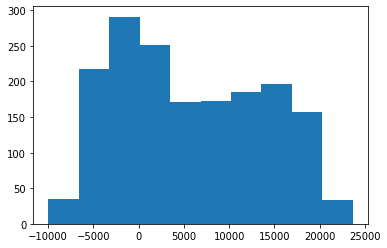

NameError: name 'array' is not defined